# Practical Session 3 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from forban import *
from forban.bandits import NormalBandit, Normal
from forban.sequentialg import SequentiAlg
from forban.utils import *

# Part I - Best Arm Identification

### Question 0

Recall the `forban` module.

### Question 1

What are the three main parts of an exploration algorithm that aims to identify the best arm (*i.e.*, the arm having the largest mean).

### Exploration class template

In [2]:
class Exploration(SequentiAlg):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stoping criterion': None }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = params['stoping criterion']
        
    def compute_indices(self):
        pass
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        pass
    
    def stop(self):
        pass
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

## Template for doing experiments

In [3]:
class Experiment:
    def __init__(self, sequential_algorithms, bandit,
                 statistics={'distance':True, 'proba':True, 'pulls':True}):
        assert len(sequential_algorithms) > 0
        self.algorithms = sequential_algorithms
        self.bandit = bandit
        self.nbr_algo = len(sequential_algorithms)
        self.algo_idx = 0
        self.statistics = {}
        self.nbr_exp = None
        for algo_idx, algo in enumerate(self.algorithms):
            self.statistics[algo_idx] = {'name': algo.name}
            for s in statistics.items():
                if s[1]:
                    self.statistics[algo_idx][s[0]] = None
        stats = self.statistics[0].keys()
        self.stats = stats

    def run(self, nbr_exp=500):
        self.nbr_exp = nbr_exp
        for algo_idx, algo in enumerate(self.algorithms):
            reco_arms = np.zeros(nbr_exp+self.bandit.nbr_arms, int)
            delta = np.zeros(nbr_exp+self.bandit.nbr_arms)
            pulls = np.zeros(nbr_exp, int)
            for i in range(nbr_exp):
                
                algo.reset()
                algo.run()
                
                reco_arms[i] = algo.recommendation()
                delta[i] = self.bandit.regrets[reco_arms[i]]
                pulls[i] = np.sum(algo.nbr_pulls)
            
            reco_arms[nbr_exp:] = np.arange(self.bandit.nbr_arms)
            delta[nbr_exp:] = self.bandit.regrets
            for k in self.stats:
                if k == 'distance':
                    self.statistics[algo_idx][k] = delta.copy()
                elif k == 'proba':
                    self.statistics[algo_idx][k] = reco_arms.copy()
                elif k == 'pulls':
                    self.statistics[algo_idx]['pulls'] = pulls.copy()
                    
    def plot(self, normalisation=False):
        exp_info = f"Nbr. of experiments = {self.nbr_exp}"
        ticks = np.arange(self.bandit.nbr_arms)
        if 'proba' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of recommendation\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Arm", fontsize=14)
            plt.xticks(ticks, [str(i) for i in range(self.bandit.nbr_arms)])
            
            n = self.nbr_algo
            w = 1/(2*n)
            
            for i, algo_stats in enumerate(self.statistics.values()):
                name = algo_stats['name']
                _, hist = np.unique(algo_stats['proba'], return_counts=True)
                hist = hist - np.ones(self.bandit.nbr_arms, int)
                if normalisation:
                    hist = hist / self.nbr_exp
                t = ticks + w*(i - (n-1)/2)
                plt.bar(t, hist, width=w, label=name, alpha=0.5)
    
            plt.legend()
            plt.show()
        
        ticks = np.sort(self.bandit.regrets)
        if 'distance' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of recommendation regret\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Arm - regret", fontsize=14)
            idxs = np.argsort(self.bandit.regrets)
            tmp = self.bandit.regrets[idxs]
            tmp = np.abs(tmp[1:] - tmp[:-1])
            w = np.unique(tmp)
            w = w[w > 0]
            
            n = self.nbr_algo
            w = w[0] / (2*n)
            
            
            plt.xticks(ticks, [f"{idxs[i]} - {self.bandit.regrets[idxs[i]]:.3f}" for i in range(self.bandit.nbr_arms)])

            for i, algo_stats in enumerate(self.statistics.values()):
                name = algo_stats['name']
                delta = algo_stats['distance']
                _, hist = np.unique(delta, return_counts=True)
                hist = hist - np.ones(self.bandit.nbr_arms, int)
                if normalisation:
                    hist = hist / self.nbr_exp
                t = ticks + w*(i - (n-1)/2)
                plt.bar(t, hist, width=w, label=name, alpha=0.5)
    
            plt.legend()
            plt.show()

### Question 3
Using the `Exploration` class, implement an exploration algorithm with uniform allocation. Test different recommendation rules on different bandit problem (having different complexities as defined in the previous homework).

### Exempli Gratia

Please, try to implement your own version (*i.e.*, own uniform allocation sampling rule) of the following example. 

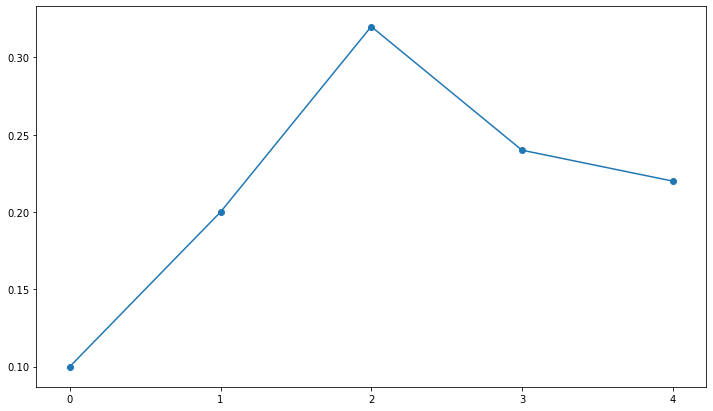

In [4]:
bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])
plot_bandit(bandit_instance)

In [5]:
class ExplorationUniform(Exploration):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stoping criterion': 500 }):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = params['stoping criterion']
        
    def compute_indices(self):
        self.indices = np.random.randn(self.bandit.nbr_arms)
        # self.indices = - self.nbr_pulls
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        return randamax(self.means)
    
    def stop(self):
        return self.time > self.stoping_criterion
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

In [6]:
uniform_1 = ExplorationUniform(bandit_instance)
uniform_2 = ExplorationUniform(bandit_instance, name="Exploration 2", params={'init': 0, 'stoping criterion': 1500 })

In [7]:
expe = Experiment([uniform_1, uniform_2], bandit_instance)

In [8]:
expe.run(200)

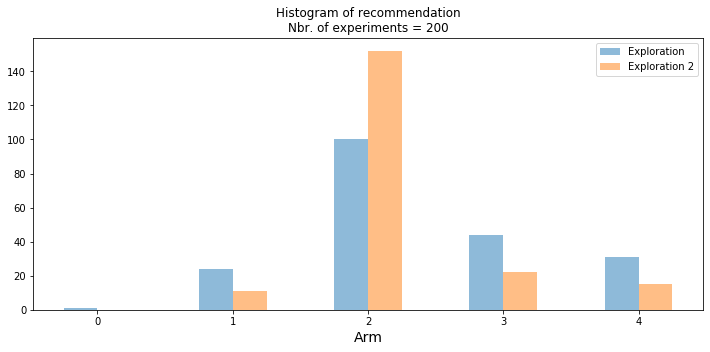

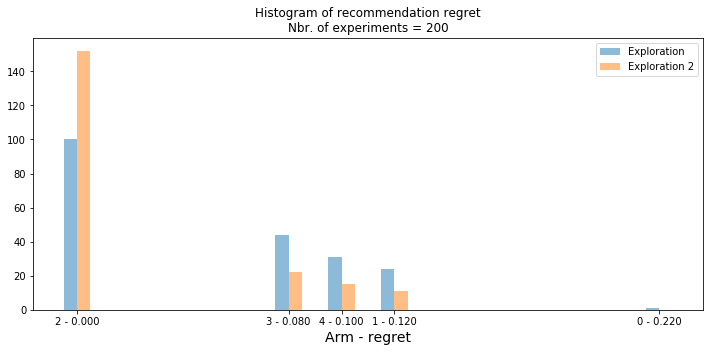

In [9]:
expe.plot()

### Question 4
Using the `Exploration` class, implement an UCB like exploration algorithm. Test different recommendation rules on different bandit problems (having different complexities as defined two sessions ago).

### Question 5
Using the `Exploration` class, implement the sequential halving algorithm with a fixed budget. Test it on different bandit problems (having different complexities as defined two sessions ago).

### Question 6
Do you think using structure would help for BAI?